# 0. Install and Import Dependencies

In [1]:
!pip list

Package                      Version
---------------------------- ---------
absl-py                      1.4.0
asttokens                    2.2.1
astunparse                   1.6.3
backcall                     0.2.0
beautifulsoup4               4.12.0
cachetools                   5.3.0
certifi                      2022.12.7
charset-normalizer           3.1.0
colorama                     0.4.6
comm                         0.1.3
contourpy                    1.0.7
cycler                       0.11.0
debugpy                      1.6.6
decorator                    5.1.1
executing                    1.2.0
filelock                     3.10.7
flatbuffers                  23.3.3
fonttools                    4.39.3
gast                         0.4.0
gdown                        4.7.1
google-auth                  2.17.1
google-auth-oauthlib         1.0.0
google-pasta                 0.2.0
grpcio                       1.53.0
h5py                         3.8.0
idna                         3.4
image

In [2]:
!pip install opencv-python matplotlib imageio gdown

In [3]:
!pip install tensorflow

In [4]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio
import winsound

In [5]:
# Check if we have a GPU available and, if so, prevent exponential memory growth on it so that we don't get 'Out of memory' errors
physical_devices = tf.config.list_physical_devices('GPU')
print("GPUs:", physical_devices)

try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

GPUs: []


# 1. Build Data Loading Functions

In [6]:
if (not os.path.exists("data")):
    
    import gdown # Library to download data from Google Drive
    
    url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
    filename = 'data.zip'
    gdown.download(url, filename, quiet=False)
    gdown.extractall(filename)
    os.remove(filename)

In [7]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)    # Load the video
    frames = []
    
    # Loop through the frames and store them in the frames list
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        
         # We only store a rectangular slice of the frame that contains the lips.
         # We can do this because the lips are always in the same position.
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    # Standarize frames (so that they have a mean=0 and std=1)
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    frames_standarized = tf.cast((frames - mean), tf.float32) / std
    
    return(frames_standarized)

In [8]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [9]:
# Create two functions than convert characters to numbers and viceversa (a=1, b=2, z=26, !=29, '1'=30, etc)
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")

num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(),
                                           oov_token="",  # "Out of vocabulary" token
                                           invert=True)


print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [10]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11], dtype=int64)>

In [11]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [12]:
def load_alignments(path:str) -> List[str]: 
    """ Load and parse file with transcribed text. It contains lines such as:
            0 23750 sil
            23750 29500 bin
            29500 34000 blue
            34000 35500 sil
    """
    with open(path, 'r') as f:
        lines = f.readlines()
    
    tokens = []
    
    for line in lines:
        line = line.split()                # Get list of words in the line. Actual word is in position 2
        if (line[2] == 'sil'): continue    # Ignore silences
        tokens = [*tokens, ' ', line[2]]   # 
    
    # Convert from chars to numbers
    charList = tf.strings.unicode_split(tokens, input_encoding='UTF-8')    # [won, ,last] --> [[w,o,n],[ ],[l,a,s,t]]
    charListOneArray = tf.reshape( charList , (-1))                        # [[w,o,n],[ ],[l,a,s,t]]  ->>  [w,o,n, ,l,a,s,t]
    nums = char_to_num(charListOneArray)                                   # Convert to array of numbers
    nums = nums[1:] # Remove first value which is usually a ' ' due to initial silence
    
    return (nums)

In [13]:
def load_data(path: str):
    """ Given the path to a video or alignment file, return video and corresponding alignment data """
    path = bytes.decode(path.numpy())
    
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0] # Remove path and extension and leave only the filename
    #file_name = path.split('/')[-1].split('.')[0]  # Use this on Linux or Mac
    video_path     = os.path.join('data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')
    
    frames     = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return(frames, alignments)

In [14]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [15]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

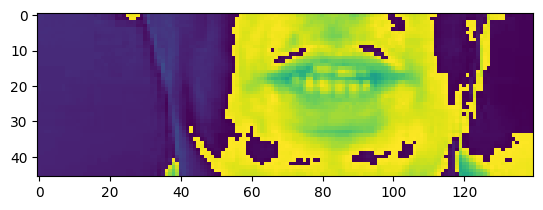

In [16]:
plt.imshow(frames[40])

In [17]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [18]:
def mappable_function(path:str) -> List[str]:
    result = tf.py_function(func=load_data,
                            inp=[path],
                            Tout=(tf.float32, tf.int64))
    return(result)

# 2. Create Data Pipeline

In [19]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')     # Prepare dataset (list of video files to process)
data = data.shuffle(500, reshuffle_each_iteration=False) # Shuffle them
data = data.map(mappable_function)    # Apply the 'load_data' function to actually get the frame and alignment data from each path 

data = data.padded_batch(
    batch_size=2,                                # Each batch has 2 videos-alignment pairs
    padded_shapes=([75,None,None,None],[40]))    # Pad to 75 frames, do not pad video dimensions or color values. Pad alignments to 40 tokens

data = data.prefetch(tf.data.AUTOTUNE) # Optimize pipeline by preloading as the ML model is still training

In [20]:
# Train/test split
train = data.take(450)
test  = data.skip(450)
print(len(train), len(test))

450 50


In [21]:
# Load 2 videos and 2 alignments
frames, alignments = data.as_numpy_iterator().next()

In [22]:
print(len(frames)) # Note how there's 2 videos
alignments         # Note how there are 2 alignments and they're padded with 0s

2


array([[ 2,  9, 14, 39,  2, 12, 21,  5, 39,  9, 14, 39, 26, 39, 26,  5,
        18, 15, 39, 14, 15, 23,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [19,  5, 20, 39,  2, 12, 21,  5, 39,  2, 25, 39, 21, 39, 26,  5,
        18, 15, 39, 14, 15, 23,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [23]:
sample = data.as_numpy_iterator()

In [24]:
val = sample.next()
val[0]

array([[[[[1.452581  ],
          [1.452581  ],
          [1.452581  ],
          ...,
          [0.223474  ],
          [0.18622833],
          [0.18622833]],

         [[1.452581  ],
          [1.452581  ],
          [1.452581  ],
          ...,
          [0.223474  ],
          [0.18622833],
          [0.18622833]],

         [[1.4153353 ],
          [1.4153353 ],
          [1.4153353 ],
          ...,
          [0.26071966],
          [0.29796535],
          [0.29796535]],

         ...,

         [[1.0428786 ],
          [1.0428786 ],
          [1.0428786 ],
          ...,
          [0.03724567],
          [0.        ],
          [0.        ]],

         [[1.005633  ],
          [1.005633  ],
          [1.005633  ],
          ...,
          [0.        ],
          [9.497645  ],
          [9.497645  ]],

         [[1.005633  ],
          [1.005633  ],
          [1.005633  ],
          ...,
          [0.        ],
          [9.497645  ],
          [9.497645  ]]],


        [[[1.4898

In [25]:
# Example: Convert numpy array to gif. Use the 1st video from the 1st batch
imageio.mimsave('./animation.gif', val[0][0], fps=10)

Lossy conversion from float32 to uint8. Range [0.0, 9.497645378112793]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.497645378112793]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.497645378112793]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.497645378112793]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.497645378112793]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.497645378112793]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.497645378112793]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. R

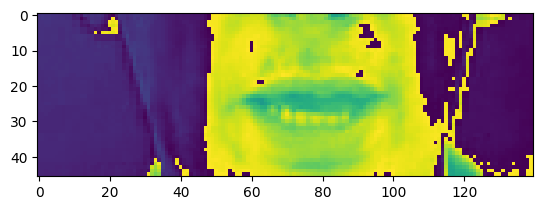

In [26]:
# Plot a single frame
# 0:videos, 0: 1st video out of the batch,  35: frame number 
plt.imshow(val[0][0][35])

In [27]:
# Revert the alignment to text (as a single string)
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay blue sp at q five soon'>

# 3. Design the Deep Neural Network

In [51]:
from tensorflow.keras.models import Sequential 

from tensorflow.keras.layers import Conv3D  # 3D convolution layer. Very good for videos
from tensorflow.keras.layers import LSTM    # Long Short-Term Memory layer. Checks HW and chooses adequate implementation to maximize performance
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, MaxPool3D, Activation, TimeDistributed, Flatten

from tensorflow.keras.optimizers.legacy import Adam

from tensorflow.keras.callbacks import ModelCheckpoint          # To save copies of the model after every N epochs
from tensorflow.keras.callbacks import LearningRateScheduler    # To start out fast and slow down as we get to our optimization point (min value of loss we could potentially get to)

In [52]:
# Get the input shape we'll use as input_shape in the first Conv3D in the next cell
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [53]:
model = Sequential()

model.add(Conv3D(filters=128, kernel_size=3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu')) # Rectified linear unit, i.e. max(0, x)
model.add(MaxPool3D((1,2,2))) # Take max value inside a 1x2x2 rolling container and condense into a single pixel

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [32]:
5*17*75

6375

In [33]:
yhat = model.predict(val[0])

1/1 [==============================] - 8s 8s/step


In [34]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'3                                                   '>

In [35]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'3                                                   '>

Doesn't look like anything useful but we should get better results after we train the model.

In [36]:
model.input_shape

(None, 75, 46, 140, 1)

In [37]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [38]:
def scheduler(epoch, lr):
    if (epoch < 30):  return lr
    else:             return lr * tf.math.exp(-0.1)

In [54]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [55]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [56]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [57]:
## Define callbacks
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)

schedule_callback = LearningRateScheduler(scheduler)

example_callback = ProduceExample(test)

In [48]:
# Train model. This will take a long time, but will save each epoch in case the training is interrupted.
# Note: we can skip the training and just download the trained model in the next section
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

winsound.Beep(frequency=3500, duration=200) # Play beep when we finish
winsound.Beep(frequency=4500, duration=300)

Epoch 1/100
 13/450 [..............................] - ETA: 11:56:06 - loss: 144.9874

# 5. Make a Prediction 

Training would take a very long time, so we'll download an already trained model

In [ ]:
# Download trained model (after 96 checkpoints)
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

In [58]:
model.load_weights('models/checkpoint')

In [59]:
test_data = test.as_numpy_iterator()

In [60]:
sample = test_data.next()

In [61]:
yhat = model.predict(sample[0])

1/1 [==============================] - 5s 5s/step


In [62]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'place green with l zero now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin red by t zero now'>]

In [63]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [64]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'place green with zero now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin red by t zero now'>]

# Test on a Video

In [65]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [66]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [67]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 2s 2s/step


In [68]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [69]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]